In [1]:
from pathlib import Path
import json
from rich import print
import logging

from daq_data.client import DaqDataClient
from daq_data.plot import PanoImagePreviewer, PulseHeightDistribution

%load_ext autoreload
%autoreload 2

In [2]:
# Configure paths
cfg_dir = Path('daq_data/config')

daq_config_file = 'daq_config_grpc_simulate.json'
network_config_file = 'network_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'

daq_config_path = cfg_dir / daq_config_file
network_config_path = cfg_dir / network_config_file
hp_io_config_path = cfg_dir / hp_io_config_simulate_file

# Load configuration files
with open(hp_io_config_path, 'r') as f:
    hp_io_cfg = json.load(f)


## Minimal StreamImages Client

In [3]:
with DaqDataClient(daq_config_path, network_config_path) as client:
    # 1. Get valid hosts
    valid_hosts = client.get_valid_daq_hosts()
    if not valid_hosts:
        raise RuntimeError("No valid DAQ hosts found.")
    print(client.get_daq_host_status())

    # 2. Initialize servers in simulation mode
    all_init_success = client.init_sim(hosts=[])
    if not all_init_success:
        raise RuntimeError("Failed to initialize one or more servers.")
    print("All servers initialized for simulation.")

    # 3. Stream pulse-height and movie data from all modules
    image_stream = client.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        module_ids=()
    )

    # 4. Listen to the stream and process data
    print("Starting data stream. Press Ctrl+C to stop.")
    for image_data in image_stream:
        # In a real application, you would pass this data to a
        # visualization or analysis function.
        print(
            f"Image: Module {image_data['module_id']}, "
            f"Type: {image_data['type']}, "
            f"Timestamp: {image_data['header']['pandas_unix_timestamp']}"
        )

{'10.0.0.60:50051': True, 'localhost:50051': True}

19:32:28 INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with {'data_dir':     ]8;id=383521;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=162664;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#403\403]8;;\
                  'simulated_data_dir', 'update_interval_seconds': 0.1, 'force': True,                             
                  'simulate_daq': True, 'module_ids': []}                                                          

19:32:31 INFO     [tid=8757206784] [init_hp_io()] host='localhost': init_hp_io_response.success=True  ]8;id=221539;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=657760;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#407\407]8;;\

         INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with {'data_dir':     ]8;id=263441;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=425829;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#403\403]8;;\
                  'simulated_data_dir', 'update_interval_seconds': 0.1, 'force': True,                             
                  'simulate_daq': True, 'module_ids': []}                                                          

19:32:33 INFO     [tid=8757206784] [init_hp_io()] host='10.0.0.60': init_hp_io_response.success=True  ]8;id=838845;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=9280;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#407\407]8;;\

All servers initialized for simulation.

         INFO     [tid=8757206784] [stream_images()] stream_images_request={'stream_movie_data':      ]8;id=202884;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=755249;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#317\317]8;;\
                  True, 'stream_pulse_height_data': True, 'update_interval_seconds': 1.0,                          
                  'module_ids': []}                                                                                

         INFO     [tid=8757206784] [stream_images()] Created StreamImages RPC to host='localhost'     ]8;id=700700;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=215172;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#327\327]8;;\

         INFO     [tid=8757206784] [stream_images()] Created StreamImages RPC to host='10.0.0.60'     ]8;id=945390;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py\client.py]8;;\:]8;id=306686;file:///Users/nico/panoseti/panoseti_grpc/daq_data/client.py#327\327]8;;\

Starting data stream. Press Ctrl+C to stop.

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:31.847077264

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:12.380759969

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.732007488

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:28.153392006

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:37.823393448

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:32.203966877

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.742007488

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:38.134152569

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:43.602434813

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:44.585929913

Image: Module 224, Type: MOVIE, Timestamp: 2024-07-25 04:34:52.752007488

Image: Module 72, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:53.762172895

Image: Module 224, Type: PULSE_HEIGHT, Timestamp: 2024-07-25 04:35:53.344925995

## Visualization Client Example

In [9]:
# initialize the server
with DaqDataClient(daq_config_path, network_config_path, log_level=logging.WARNING) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")
    service_summary = ddc.reflect_services([])
    print(service_summary)
    all_init_success = ddc.init_sim([])
    print(f"\t{all_init_success=}")


19:35:05 INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=344320;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=77219;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=694823;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=607808;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=365845;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=211517;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=259119;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=837213;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/empty.proto                                               

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=603814;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=495166;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=844302;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=159961;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=521335;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=678560;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=557588;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=461220;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/empty.proto                                               

Reflecting services on localhost:50051:
        found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']
        found DaqData service with name: daqdata.DaqData
        found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)
        found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)
        found: rpc Ping(Empty) returns (Empty)
Reflecting services on 10.0.0.60:50051:
        found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']
        found DaqData service with name: daqdata.DaqData
        found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)
        found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)
        found: rpc Ping(Empty) returns (Empty)

all_init_success=True

#### Streaming from One DAQ node

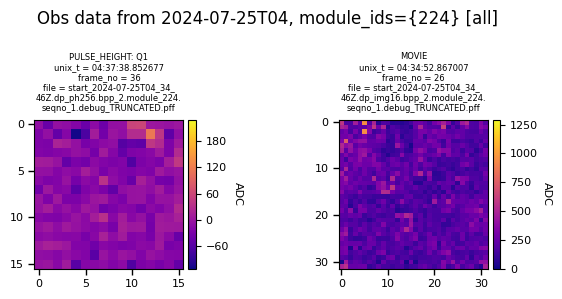

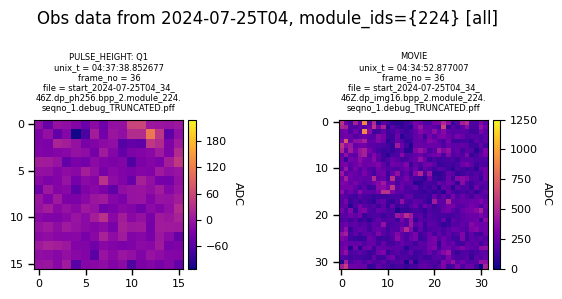

In [10]:
# Show PanoImagePreviewer: One DAQ node

with DaqDataClient(daq_config_path, network_config_path) as ddc:
    
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        # module_id_whitelist=[],
        jupyter_notebook=True
    )

    # Get first valid daq node
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    host = list(valid_daq_hosts)[0] 
    
    # Call the StreamImages RPC on one valid DAQ node
    pano_image_stream = ddc.stream_images(
        host,
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update visualization
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

#### Streaming from Multiple DAQ Nodes

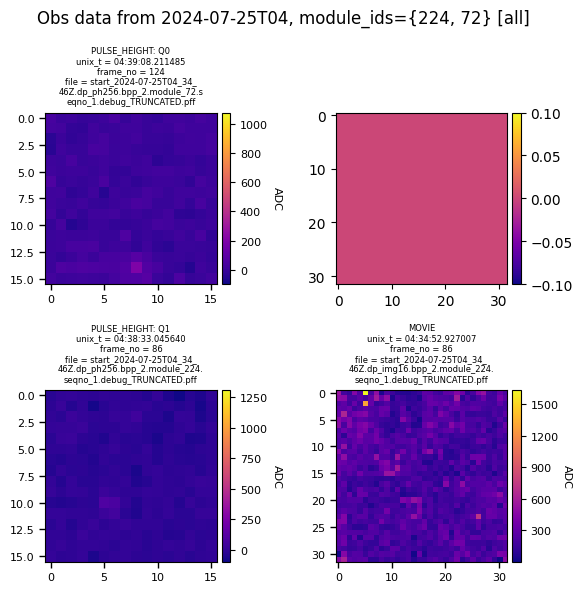

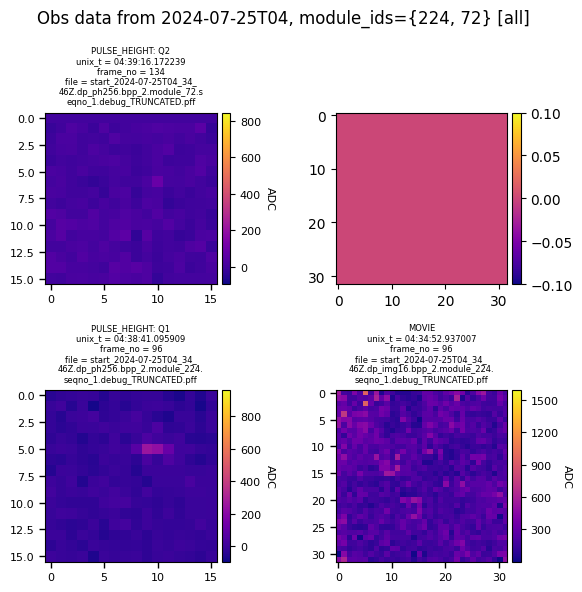

In [11]:
# Show PanoImagePreviewer: Multiple DAQ nodes

# 1. Connect to all DAQ nodes
with DaqDataClient(daq_config_path, network_config_path) as ddc:
    
    # 2. Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data=True,
        stream_pulse_height_data=True,
        module_id_whitelist=[],
        jupyter_notebook=True
    )
    
    # 3. Call the StreamImages RPC on all valid DAQ nodes
    pano_image_stream = ddc.stream_images(
        hosts=[],
        stream_movie_data=True,
        stream_pulse_height_data=True,
        update_interval_seconds=1.0,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # 4. Update visualization for each pano_image
    for pano_image in pano_image_stream:
        previewer.update(pano_image)